In [0]:
!pip install torch
!pip install torchvision
!pip install gym
!pip install gym[atari]

    100% |████████████████████████████████| 519.5MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59f7c000 @  0x7f1eeb86d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 7.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 1.5MB 15.3MB/s 
    100% |████████████████████████████████| 1.0MB 22.2MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
    100% |████████████████████████████████| 2.6MB

In [0]:
import gym
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils, datasets
import torchvision.models as models
import os
from IPython import display
from itertools import chain
from tqdm import tqdm
from functools import reduce
import atari_py



In [0]:


 
class PolicyNetwork(nn.Module):
    def __init__(self, inOpts, outOpts):
      super(PolicyNetwork, self).__init__()
      self.net=nn.Sequential(nn.Linear(inOpts, 10),
                            nn.ReLU(), 
                            nn.Linear(10,10),
                            nn.ReLU(),
                            nn.Linear(10,10),
                            nn.ReLU(),
                            nn.Linear(10, outOpts))
      self.softmax = nn.Softmax(dim=1)
    
    def forward(self, env, justProbs=False):
      scores= self.net(env)
      scores = scores/5
      probs=self.softmax(scores)
      if justProbs:
        return probs
      batch_size=env.shape[0]
      actions = np.empty((batch_size,1), dtype=np.uint8)
      probs_np = probs.cpu().detach().numpy()

      for i in range(batch_size):
        if probs_np[i][0] >.995:
          probs_np[i][0]=.99
        action_one_hot = np.random.multinomial(1, probs_np[i])
        action_idx = np.argmax(action_one_hot)
        actions[i,0] = action_idx
      return(probs, actions)
 

class ValueNetwork(nn.Module):
    def __init__(self, num):
      super(ValueNetwork, self).__init__()
      self.num=num
      self.net=nn.Sequential(
      nn.Linear(self.num,10),
      nn.ReLU(),
      nn.Linear(10,10), 
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10,1))
      
    def forward(self, x):
      return(self.net(x))
      
      
      
class AdvantageDataset(Dataset):                                                                                                                    
    def __init__(self, experience):                                                                                                                 
        super(AdvantageDataset, self).__init__()                                                                                                    
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp[0], chosen_exp[4]                                                                                                         
 
    def __len__(self):                                                                                                                              
        return self._length                                                                                                                         
 
 
class PolicyDataset(Dataset):                                                                                                                       
    def __init__(self, experience):                                                                                                                 
        super(PolicyDataset, self).__init__()                                                                                                       
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp                                                                                                                           
 
    def __len__(self):                                                                                                                              
        return self._length                                                                                                                         
 
 
def calc_returns(rollout, gamma):
  current_return = 0
  for i in reversed(range(len(rollout))):
    state, action_dist, action, reward = rollout[i]
    ret= reward+gamma*current_return
    rollout[i] = (state, action_dist, action, reward, ret)
    current_return = ret
    
def multinomial_likelihood(dist, idx):
    return dist[range(dist.shape[0]), idx.long()[:, 0]].unsqueeze(1)


In [96]:
def main():
 
    env = gym.make('CartPole-v0')
    
    policy = PolicyNetwork(4, 2)
    value = ValueNetwork(4)
    #Not sure why cuda isn't working, will come back to if necessary
    #policy=policy.cuda()
    #value=value.cuda()
    params = chain(policy.parameters(), value.parameters())
    optimizer = optim.Adam(params, lr= .001, betas = (.9, .999), weight_decay=.01)
    value_criteria = nn.MSELoss()
    
    epsilon = .2
    ppo_lb = 1-epsilon
    ppo_ub = 1+epsilon
    
    epochs=45
    policy_epochs = 5
    num_rollouts = 100
    max_ep_length= 200
    gamma=.99
    batch_size=256
    val_losses=[]
    policy_losses=[]
    avg_reward=[]
    
    loop = tqdm(total=epochs, position = 0, leave=False)
    
    for e in range(epochs):
      #print(e)
      experiences=[]
      rewards = []
      for _ in range(num_rollouts):
        current_rollout=[]
        s = env.reset()
        episode_reward=0
        for b in range(max_ep_length):
          state = torch.from_numpy(s).float().unsqueeze(0)
          action_dist, action = policy(state)
          action_dist, action = action_dist[0], action[0]
          #print(action)
          s_prime, r, t, _ = env.step(action.item())
          current_rollout.append((s, action_dist.cpu().detach().numpy(), action, r))
          episode_reward+=r
          if t: 
            break
          s=s_prime
        calc_returns(current_rollout, gamma)
        experiences.append(current_rollout)
        rewards.append(episode_reward)
      
      #return(rewards)
      #print(len(experiences))
      #print(experiences)
   
      avg_r = np.mean([x[0][4] for x in experiences])
      #loop.set_description('average reward: % 6.2f' % (avg_r))
      experience_dataset = PolicyDataset(experiences)
      data_loader = DataLoader(experience_dataset, batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=True)

      avg_policy_loss=0
      avg_val_loss=0
      for i in range(policy_epochs):
        avg_policy_loss = 0
        avg_val_loss = 0
        for state, old_action_dist, old_action, reward, ret in data_loader:
          #print(state.size(), old_action_dist.size(), old_action.size(), reward.size(), ret.size())
          optimizer.zero_grad()
          act_dist=policy(state.float(),True)
          current_likelihood = multinomial_likelihood(act_dist, old_action)
          old_likelihood = multinomial_likelihood(old_action_dist, old_action)
          ratio = (current_likelihood / old_likelihood).squeeze(1)
          
          expected_returns = value(state.float())
          val_loss = value_criteria(expected_returns.squeeze(1), ret.float())
          #print(ret.size())
          #print(expected_returns.squeeze(1).size())
          advantage = ret.float() - expected_returns.squeeze(1)
          #print(advantage.size())
          #print(ratio.size())
          #printaasfd
          lhs = ratio * advantage
          #print(lhs.size())
          rhs = torch.clamp(ratio, ppo_lb, ppo_ub) * advantage
          #print(rhs.size())
          policy_loss = -torch.mean(torch.min(lhs, rhs))

          # For logging
          avg_val_loss += val_loss.item()
          avg_policy_loss += policy_loss.item()
          val_losses.append(val_loss.item())
          policy_losses.append(policy_loss.item())

          # Backpropagate
          loss = policy_loss + val_loss
          loss.backward()
          optimizer.step()
      avg_val_loss /= len(data_loader)
      avg_policy_loss /= len(data_loader)
      avg_reward.append(avg_r)
      loop.set_description('avg reward: % 6.2f, value loss: % 6.2f, policy loss: % 6.2f' % (avg_r, avg_val_loss, avg_policy_loss))
      loop.update(1)
    return policy, value, val_losses, policy_losses, avg_reward
            
rewards=main()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
avg reward:  85.56, value loss:  207.99, policy loss:  -0.53: 100%|██████████| 45/45 [04:33<00:00,  7.67s/it]

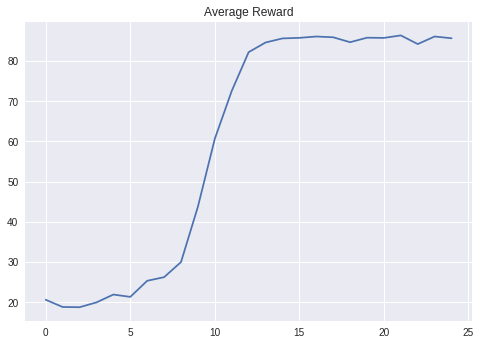

In [98]:
#print(rewards)
#plt.plot(rewards[2])
#plt.show()
#plt.plot(rewards[3])
#plt.show()
plt.plot(rewards[4][0:25])
plt.title("Average Reward")
plt.show()


In [78]:
def main():

  env = gym.make('MountainCar-v0')
  env.reset()
  print(env.action_space)
  
  policy = PolicyNetwork(2, 3)
  value = ValueNetwork(2)
  #Not sure why cuda isn't working, will come back to if necessary
  #policy=policy.cuda()
  #value=value.cuda()
  params = chain(policy.parameters(), value.parameters())
  optimizer = optim.Adam(params, lr= .01, betas = (.9, .999))
  value_criteria = nn.MSELoss()

  epsilon = .2
  ppo_lb = 1-epsilon
  ppo_ub = 1+epsilon

  epochs=100
  policy_epochs = 5
  num_rollouts = 100
  max_ep_length= 200
  gamma=.99
  batch_size=256
  val_losses=[]
  policy_losses=[]
  avg_reward=[]
  best_location=-.5
  best_velocity=0

  loop = tqdm(total=epochs, position = 0, leave=False)
  #for p in policy.parameters():
   # print(p)
  madeIt=False
  for e in range(epochs):
    #print(e)
    experiences=[]
    rewards = []
    for _ in range(num_rollouts):
      current_rollout=[]
      s = env.reset()
      episode_reward=0
      for b in range(max_ep_length):
        state = torch.from_numpy(s).float().unsqueeze(0)
        #print(s)
        #print(state)
        action_dist, action = policy(state)
        action_dist, action = action_dist[0], action[0]
        #print(action)
        s_prime, r, t, _ = env.step(action.item())
        if t and b<199 and not madeIt: 
          print("You made it to the top!!!")
          madeIt=True
          epochCounter=0
        location = s_prime[0]  
        velocity=s_prime[1]
        #print(r)
        if abs(location+.5) > abs(best_location+.5):
          best_location=location
          #print("New best location", location)
        if (abs(velocity)>abs(best_velocity)):
          best_velocity = velocity
          print("new best velocity:", velocity)
        if not madeIt:
          r=-(.007-abs(velocity))/.007
        if madeIt:
          if epochCounter<20:
            epochCounter+=1
            r =r*(epochCounter)/20 -  (20-epochCounter)/20 *(.007-abs(velocity))/.007
            
        #if e>9 & e<25:
         #  m = e-15
          # r = r*m/14 + abs(velocity)/.07*(14-m)/14
        #if b==199:
          #print(r)
          #print(velocity)
        #print(s_prime)
        #print(r)
        current_rollout.append((s, action_dist.cpu().detach().numpy(), action, r))
        episode_reward+=r
        if t: 
          break
        s=s_prime
      calc_returns(current_rollout, gamma)
      experiences.append(current_rollout)
      rewards.append(episode_reward)

    #return(rewards)
    #print(len(experiences))
    #print(experiences)
    avg_r = np.mean([x[0][4] for x in experiences])
    #loop.set_description('average reward: % 6.2f' % (avg_r))
    experience_dataset = PolicyDataset(experiences)
    data_loader = DataLoader(experience_dataset, batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)
    avg_policy_loss=0
    avg_val_loss=0
    for i in range(policy_epochs):
      avg_policy_loss = 0
      avg_val_loss = 0
      for state, old_action_dist, old_action, reward, ret in data_loader:
        #print(state.size(), old_action_dist.size(), old_action.size(), reward.size(), ret.size())
        optimizer.zero_grad()
        act_dist=policy(state.float(),True)
        current_likelihood = multinomial_likelihood(act_dist, old_action)
        old_likelihood = multinomial_likelihood(old_action_dist, old_action)
        ratio = (current_likelihood / old_likelihood).squeeze(1)

        expected_returns = value(state.float())
        val_loss = value_criteria(expected_returns.squeeze(1), ret.float())
        #print(ret.size())
        #print(expected_returns.squeeze(1).size())
        advantage = ret.float() - expected_returns.squeeze(1)
        #print(advantage.size())
        #print(ratio.size())
        #printaasfd
        lhs = ratio * advantage
        #print(lhs.size())
        rhs = torch.clamp(ratio, ppo_lb, ppo_ub) * advantage
        #print(rhs.size())
        policy_loss = -torch.mean(torch.min(lhs, rhs))

        # For logging
        avg_val_loss += val_loss.item()
        avg_policy_loss += policy_loss.item()
        val_losses.append(val_loss.item())
        policy_losses.append(policy_loss.item())

        # Backpropagate
        loss = policy_loss + val_loss
        loss.backward()
        optimizer.step()

    avg_val_loss /= len(data_loader)
    avg_policy_loss /= len(data_loader)
    avg_reward.append(avg_r)
    loop.set_description('avg reward: % 1.5f, value loss: % 6.2f, policy loss: % 6.2f' % (avg_r, avg_val_loss, avg_policy_loss))
    loop.update(1)
    #for p in policy.parameters():
     # print(p)
  return policy, value, val_losses, policy_losses, avg_reward
            
rewards=main()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
  0%|          | 0/100 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(3)
new best velocity: -7.832184772616844e-05
new best velocity: 0.0008439434322210839
new best velocity: -0.0014022231672778246
new best velocity: -0.002471555708810075
new best velocity: -0.003522356976295016
new best velocity: -0.004546743676511852
new best velocity: -0.005214241618767724
new best velocity: -0.006046906575875884
new best velocity: 0.0065253086793584
new best velocity: 0.007541993953204564
new best velocity: 0.008502116087549732
new best velocity: 0.008975441582054097
new best velocity: 0.00905086953306019
new best velocity: 0.010058427399425038
new best velocity: 0.010990555412161202
new best velocity: -0.011742889755754281
new best velocity: -0.012161967944347646
new best velocity: 0.012175287992823806
new best velocity: 0.012444019827648457
new best velocity: 0.013619796590725274
new best velocity: 0.01469355932414677
new best velocity: 0.015510859196448097
n

avg reward: -26.14023, value loss:  562.68, policy loss:  -0.97:   1%|          | 1/100 [00:07<12:33,  7.61s/it]

new best velocity: -0.028705206365217534
new best velocity: -0.028949827414463777
new best velocity: 0.029168040696125937
new best velocity: 0.03060306201674431
new best velocity: 0.03181054723305959
new best velocity: -0.03225067933824307
new best velocity: -0.034391229386110854
new best velocity: -0.035296594189937455
new best velocity: -0.03695059350396363


avg reward: -30.92563, value loss:  458.13, policy loss:  -0.79:   3%|▎         | 3/100 [00:23<12:34,  7.78s/it]

new best velocity: 0.03769494085642706
new best velocity: -0.038825485621695466
new best velocity: -0.03906573981758384


avg reward: -6.12356, value loss:  751.25, policy loss:  -0.48:   4%|▍         | 4/100 [00:31<12:27,  7.79s/it]

new best velocity: -0.039675722628432254
new best velocity: -0.04132463421155504
new best velocity: -0.04267001959927508
new best velocity: -0.04269648759462011
new best velocity: 0.042792711249234894
new best velocity: 0.04414710793906417
new best velocity: 0.04517159875591206
new best velocity: -0.045218079950316674
new best velocity: -0.04532032358344878
new best velocity: -0.0465823222633929
new best velocity: -0.04814945787267716
new best velocity: -0.049412371008372785
new best velocity: -0.0498311181499783
new best velocity: -0.049996726323113846
new best velocity: -0.051404982082828926
new best velocity: -0.05352712056885442
new best velocity: -0.0552776214286162
new best velocity: -0.056624176352351216


avg reward:  27.35912, value loss:  1197.85, policy loss:  -0.96:   5%|▌         | 5/100 [00:39<12:26,  7.86s/it]

new best velocity: 0.05676963658335222
new best velocity: 0.05837681870661825
new best velocity: 0.05955216418501835
new best velocity: 0.06028154382859753
new best velocity: 0.060568327670410524
new best velocity: -0.06073563648361395
new best velocity: -0.06226540116917342
You made it to the top!!!
new best velocity: -0.06259735056940999


avg reward: -85.81149, value loss:  105.29, policy loss:  -0.57:   9%|▉         | 9/100 [01:10<11:52,  7.83s/it]

new best velocity: -0.06338352167328817
new best velocity: -0.065242724148551
new best velocity: -0.06562893543704497


avg reward: -84.09631, value loss:  73.76, policy loss:  -0.51:  13%|█▎        | 13/100 [01:40<10:51,  7.48s/it]

new best velocity: -0.06696216327066207


avg reward: -76.23056, value loss:  59.90, policy loss:  -0.36:  19%|█▉        | 19/100 [02:16<08:14,  6.10s/it]

new best velocity: -0.06728325705368667
new best velocity: -0.06733734874664198


avg reward: -74.42099, value loss:  43.96, policy loss:  -0.52:  23%|██▎       | 23/100 [02:38<07:06,  5.54s/it]

new best velocity: -0.06819756791043928
new best velocity: -0.06860304433044685


avg reward: -72.85041, value loss:  38.18, policy loss:  -0.47:  25%|██▌       | 25/100 [02:49<06:44,  5.39s/it]

new best velocity: -0.06872188300237475


avg reward: -74.30630, value loss:  33.74, policy loss:  -0.49:  27%|██▋       | 27/100 [03:00<06:37,  5.45s/it]

new best velocity: -0.0690563772797817
new best velocity: -0.06983932845521051


avg reward: -68.33360, value loss:  14.90, policy loss:  -0.46:  32%|███▏      | 32/100 [03:24<05:33,  4.91s/it]

new best velocity: -0.06998933984384419


avg reward: -69.24737, value loss:  27.32, policy loss:  -0.47:  33%|███▎      | 33/100 [03:29<05:31,  4.94s/it]

new best velocity: -0.07


avg reward: -71.03624, value loss:  25.80, policy loss:  -0.50: 100%|██████████| 100/100 [08:39<00:00,  5.28s/it]

I helped it learn by initially changing the reward to be the abs(velocity). Once it reaches the flag for the first time I change the reward back to the original, now that it has a strategy on how to gain speed it has an easier time learning and reaches the flag more often.

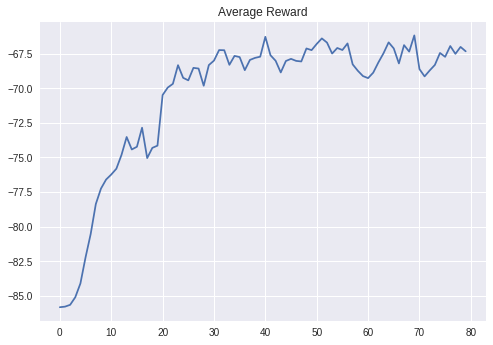

In [81]:
plt.plot(rewards[4][8:88])
plt.title("Average Reward")
plt.show()

In [93]:
policy=rewards[0]
s=np.array([-.9, -.005])
print(policy(torch.from_numpy(s).float().unsqueeze(0)))


(tensor([[0.0221, 0.0179, 0.9600]], grad_fn=<SoftmaxBackward>), array([[2]], dtype=uint8))


In [74]:
rewards



array([0.3357134 , 0.33793122, 0.3263554 ], dtype=float32)